In [1]:
from dichasus_cf0x import training_set, test_set, spec
import tensorflow as tf
import numpy as np
import tqdm

2023-10-23 07:31:51.656601: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-23 07:31:52.464027: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-10-23 07:31:53.364668: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-23 07:31:53.393766: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [2]:
def csi_time_domain(csi, pos, time):
    csi = tf.signal.fftshift(tf.signal.ifft(tf.signal.fftshift(csi, axes = -1)), axes = -1)
    return csi, pos, time

def cut_out_taps(tap_start, tap_stop):
    def cut_out_taps_func(csi, pos, time):
        return csi[:,:,:,tap_start:tap_stop], pos, time

    return cut_out_taps_func


training_set = training_set.map(csi_time_domain, num_parallel_calls = tf.data.AUTOTUNE)
training_set = training_set.map(cut_out_taps(507, 520), num_parallel_calls = tf.data.AUTOTUNE)

test_set = test_set.map(csi_time_domain, num_parallel_calls = tf.data.AUTOTUNE)
test_set = test_set.map(cut_out_taps(507, 520), num_parallel_calls = tf.data.AUTOTUNE)

# Load Data

In [3]:
dissimilarity_matrix_geodesic_meters = np.load("results/dissimilarity_matrix_geodesic_meters.npy")
classical_estimated_positions = np.load("results/estimated_positions.npy")
estimated_aoas = np.load("results/estimated_aoas.npy")
estimated_toas = np.load("results/estimated_toas.npy")
delayspreads = np.load("results/delayspreads.npy")

In [4]:
groundtruth_positions = []
csi_time_domain = []

for csi, pos, time in training_set.prefetch(tf.data.AUTOTUNE).batch(1000):
    csi_time_domain.append(csi.numpy())
    groundtruth_positions.append(pos.numpy())

csi_time_domain = np.concatenate(csi_time_domain)
groundtruth_positions = np.concatenate(groundtruth_positions)

In [5]:
# We assume that z-coordinate of TX is constant and known
HEIGHT = np.mean(groundtruth_positions[:,2])

# Manifold Learning: Finding the Low-Dimensional Representation

In [6]:
class FeatureEngineeringLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(FeatureEngineeringLayer, self).__init__(dtype = tf.complex64)

    def call(self, csi):
        # Compute sample autocorrelations for any combination of two antennas in the whole system
        # for the same datapoint and time tap.
        # csi has shape (batchsize, array, antenna row, antenna column, tap)
        sample_autocorrelations = tf.einsum("darmt,dbsnt->dtabrmsn", csi, tf.math.conj(csi))
        return tf.stack([tf.math.real(sample_autocorrelations), tf.math.imag(sample_autocorrelations)], axis = -1)

In [7]:
csi_time_domain_tensor = tf.constant(csi_time_domain)
dissimilarity_matrix_geodesic_tensor = tf.constant(dissimilarity_matrix_geodesic_meters, dtype = tf.float32)
estimated_aoas_tensor = tf.constant(estimated_aoas, dtype = tf.float32)
estimated_toas_tensor = tf.constant(estimated_toas, dtype = tf.float32)
delayspreads_tensor = tf.constant(delayspreads, dtype = tf.float32)

2023-10-23 07:32:13.315692: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1763496036 exceeds 10% of free system memory.


In [8]:
datapoint_count = tf.shape(csi_time_domain_tensor)[0].numpy()

random_integer_pairs_dataset = tf.data.Dataset.zip(tf.data.Dataset.random(), tf.data.Dataset.random())

@tf.function
def fill_pairs(randA, randB):
    indexA = randA % datapoint_count
    indexB = randB % datapoint_count
    input = (csi_time_domain_tensor[indexA], csi_time_domain_tensor[indexB])
    labels = tf.concat([[dissimilarity_matrix_geodesic_tensor[indexA, indexB]], estimated_aoas_tensor[indexA], estimated_aoas_tensor[indexB], estimated_toas_tensor[indexA], estimated_toas_tensor[indexB], delayspreads_tensor[indexA], delayspreads_tensor[indexB]], 0)
    return input, labels

random_pair_dataset = random_integer_pairs_dataset.map(fill_pairs)

2023-10-23 07:32:14.497382: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1763496036 exceeds 10% of free system memory.


### The Forward Charting Function: Defining the Neural Network

In [9]:
array_count = np.shape(csi_time_domain)[1]
rows_per_array_count = np.shape(csi_time_domain)[2]
antennas_per_row_count = np.shape(csi_time_domain)[3]
tap_count = np.shape(csi_time_domain)[4]

cc_embmodel_input = tf.keras.Input(shape = (array_count, rows_per_array_count, antennas_per_row_count, tap_count), name="input", dtype = tf.complex64)
cc_embmodel_output = FeatureEngineeringLayer()(cc_embmodel_input)
cc_embmodel_output = tf.keras.layers.Flatten()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(1024, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(512, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(256, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(128, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(64, activation = "relu")(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.BatchNormalization()(cc_embmodel_output)
cc_embmodel_output = tf.keras.layers.Dense(2, activation = "linear")(cc_embmodel_output)

cc_embmodel = tf.keras.Model(inputs = cc_embmodel_input, outputs = cc_embmodel_output, name = "ForwardChartingFunction")

# Loss function including AoA / ToA Likelihood

In [10]:
SPEED_OF_LIGHT = 299792458
BANDWIDTH = 50e6

In [11]:
# These are some empirically determined heuristics, may be further tweaked
def get_aoa_vonmises_kappas(delayspreads):
    return 0.0000003 / (delayspreads + 0.025e-7)

def get_toa_variances(delayspreads):
    return 1 + (delayspreads * 1e7) ** 4

In [12]:
array_positions = np.zeros((len(spec["antennas"]), 3))
array_normalvectors = np.zeros((len(spec["antennas"]), 3))

for antidx, antenna in enumerate(spec["antennas"]):
    array_positions[antidx] = np.asarray(antenna["location"])
    array_normalvectors[antidx] = np.asarray(antenna["direction"])

array_positions_tensor = tf.constant(array_positions, dtype = tf.float32)
array_normalvectors_tensor = tf.constant(array_normalvectors, dtype = tf.float32)

In [13]:
# Classical AoA/TDoA-based likelihood function
def classical_likelihood_func_vectorized(pos, aoas, toas, rms_delay_spreads):
    pos_with_height = tf.concat([pos, HEIGHT * tf.ones(tf.shape(pos)[0])[:, tf.newaxis]], 1)

    # "relative" has shape (number of positions, number of arrays, 3 spatial dimensions)
    relative_pos = pos_with_height[:,tf.newaxis,:] - array_positions_tensor

    # Compute ideal 2D AoAs at given positions, shape: (number of positions, number of arrays)
    ideal_aoas = tf.math.atan2(-relative_pos[:, :, 1], -relative_pos[:, :, 0]) - tf.math.atan2(-array_normalvectors_tensor[:, 1], -array_normalvectors_tensor[:, 0])

    # Compute ideal TDoAs at given positions, shape: (number of positions, number of arrays)
    ideal_toas = tf.sqrt(tf.math.reduce_sum(tf.square(relative_pos), axis = -1)) / SPEED_OF_LIGHT * BANDWIDTH

    # Compute AoA likelihoods based on von Mises distribution
    kappa = get_aoa_vonmises_kappas(rms_delay_spreads)
    aoa_likelihoods = tf.exp(kappa * tf.cos(ideal_aoas - aoas)) / (2 * np.pi * tf.math.bessel_i0(kappa))

    # Compute TDoA likelihoods based on Gaussian distribution. tdoa_difference has shape (number of positions, number of array-pairs)
    arraysA, arraysB = np.triu_indices(len(spec["antennas"]), k = 1)
    estimated_tdoas = tf.gather(toas, arraysB, axis = 1) - tf.gather(toas, arraysA, axis = 1)
    ideal_tdoas = tf.gather(ideal_toas, arraysB, axis = 1) - tf.gather(ideal_toas, arraysA, axis = 1)
    tdoa_difference = ideal_tdoas - estimated_tdoas
    variances = get_toa_variances(tf.math.maximum(tf.gather(rms_delay_spreads, arraysA, axis = 1), tf.gather(rms_delay_spreads, arraysB, axis = 1)))
    toa_likelihoods = tf.multiply(tf.divide(1, tf.sqrt(2 * np.pi * variances)), tf.exp(-0.5 * tf.divide(tf.square(tdoa_difference), variances)))

    return tf.multiply(tf.math.reduce_prod(aoa_likelihoods, axis = -1), tf.math.reduce_prod(toa_likelihoods, axis = -1))

In [14]:
def get_combined_siamese_classical_loss(classical_weight):
    def combined_siamese_classical_loss(y_true, y_pred):
        dissimilarities = y_true[:,0]
    
        pos_A, pos_B = (y_pred[:,:2], y_pred[:,2:])
        distances_pred = tf.math.reduce_euclidean_norm(pos_A - pos_B, axis = 1)
        siamese_loss = tf.reduce_mean(tf.square(distances_pred - dissimilarities))
    
        aoa_A = y_true[:,1:5]
        aoa_B = y_true[:,5:9]
        toa_A = y_true[:,9:13]
        toa_B = y_true[:,13:17]
        ds_A = y_true[:,17:21]
        ds_B = y_true[:,21:25]
        classical_loss = -tf.reduce_sum(classical_likelihood_func_vectorized(pos_A, aoa_A, toa_A, ds_A) + classical_likelihood_func_vectorized(pos_B, aoa_B, toa_B, ds_B))
        
        return classical_weight * classical_loss + (1 - classical_weight) * siamese_loss

    return combined_siamese_classical_loss

In [15]:
input_A = tf.keras.layers.Input(shape = (array_count, rows_per_array_count, antennas_per_row_count, tap_count,), dtype = tf.complex64)
input_B = tf.keras.layers.Input(shape = (array_count, rows_per_array_count, antennas_per_row_count, tap_count,), dtype = tf.complex64)

embedding_A = cc_embmodel(input_A)
embedding_B = cc_embmodel(input_B)

output = tf.keras.layers.concatenate([embedding_A, embedding_B], axis=1)
model = tf.keras.models.Model([input_A, input_B], output, name = "SiameseNeuralNetwork")

### Training

In [16]:
optimizer = tf.keras.optimizers.Adam()

# Feel free to tweak these training hyperparameters - a good choice of these paremters is important for performance!
samples_per_session = 200000
learning_rates = [5e-3, 2e-3, 1e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
batch_sizes = [400, 800, 1200, 2000, 3000, 3000, 4000, 5000]
classical_weights = [0.98, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85]


for session, learning_rate, batch_size, classical_weight in zip(range(len(learning_rates)), learning_rates, batch_sizes, classical_weights):
    print("\nTraining Session ", session + 1, "\nBatch Size: ", batch_size, "\nLearning rate: ", learning_rate)

    # Fit model
    model.compile(loss = get_combined_siamese_classical_loss(classical_weight), optimizer = optimizer)
    optimizer.learning_rate.assign(learning_rate)
    steps_per_epoch = int(samples_per_session / batch_size)
    model.fit(random_pair_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE), steps_per_epoch = samples_per_session / batch_size)

    # Quick evaluation
    channel_chart_positions = cc_embmodel.predict(csi_time_domain_tensor)
    errorvectors = groundtruth_positions[:,:2] - channel_chart_positions
    print(f"Mean Absolute Error (MAE): {np.mean(np.sqrt(errorvectors[:,0]**2 + errorvectors[:,1]**2)):.4f}m")

    #plot_colorized(channel_chart_positions, groundtruth_positions, title = "Siamese-Based Channel Chart - Training Set")
    #plot_quiver(channel_chart_positions, groundtruth_positions)


Training Session  1 
Batch Size:  400 
Learning rate:  0.005


2023-10-23 07:32:15.508992: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1763496036 exceeds 10% of free system memory.
2023-10-23 07:32:20.544080: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-23 07:32:20.570487: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55dac9319640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-23 07:32:20.570538: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2023-10-23 07:32:20.579838: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-23 07:32:20.744398: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-23 07:32:20.86085

657/657 [==============================] - 1s 2ms/step
Mean Absolute Error (MAE): 0.5370m

Training Session  2 
Batch Size:  800 
Learning rate:  0.002


2023-10-23 07:32:31.241365: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1763496036 exceeds 10% of free system memory.


657/657 [==============================] - 1s 2ms/step
Mean Absolute Error (MAE): 0.5520m

Training Session  3 
Batch Size:  1200 
Learning rate:  0.001


2023-10-23 07:32:38.933613: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1763496036 exceeds 10% of free system memory.


657/657 [==============================] - 1s 2ms/step
Mean Absolute Error (MAE): 0.4355m

Training Session  4 
Batch Size:  2000 
Learning rate:  0.001
657/657 [==============================] - 1s 1ms/step
Mean Absolute Error (MAE): 0.4367m

Training Session  5 
Batch Size:  3000 
Learning rate:  0.0005
657/657 [==============================] - 1s 2ms/step
Mean Absolute Error (MAE): 0.4104m

Training Session  6 
Batch Size:  3000 
Learning rate:  0.0001
657/657 [==============================] - 1s 2ms/step
Mean Absolute Error (MAE): 0.4029m

Training Session  7 
Batch Size:  4000 
Learning rate:  5e-05
657/657 [==============================] - 1s 2ms/step
Mean Absolute Error (MAE): 0.4001m

Training Session  8 
Batch Size:  5000 
Learning rate:  1e-05
657/657 [==============================] - 1s 2ms/step
Mean Absolute Error (MAE): 0.3996m


# Optional: Evaluation, Plots

In [17]:
import matplotlib.pyplot as plt

In [18]:
def plot_colorized(positions, reference_positions, title = None, show = True, alpha = 1.0):
    # Generate RGB colors for datapoints
    center_point = np.zeros(2, dtype = np.float32)
    center_point[0] = 0.5 * (np.min(reference_positions[:, 0], axis = 0) + np.max(reference_positions[:, 0], axis = 0))
    center_point[1] = 0.5 * (np.min(reference_positions[:, 1], axis = 0) + np.max(reference_positions[:, 1], axis = 0))
    NormalizeData = lambda in_data : (in_data - np.min(in_data)) / (np.max(in_data) - np.min(in_data))
    rgb_values = np.zeros((reference_positions.shape[0], 3))
    rgb_values[:, 0] = 1 - 0.9 * NormalizeData(reference_positions[:, 0])
    rgb_values[:, 1] = 0.8 * NormalizeData(np.square(np.linalg.norm(reference_positions[:,:2] - center_point, axis=1)))
    rgb_values[:, 2] = 0.9 * NormalizeData(reference_positions[:, 1])

    # Plot datapoints
    plt.figure(figsize=(6, 6))
    if title is not None:
        plt.title(title, fontsize=16)
    plt.scatter(positions[:, 0], positions[:, 1], c = rgb_values, alpha = alpha, s = 10, linewidths = 0)
    plt.xlabel("x coordinate")
    plt.ylabel("y coordinate")
    if show:
        plt.show()

def plot_quiver(positions, reference_positions, title = None, nth_errorvector = 15):
    errorvectors = reference_positions[:,:2] - positions
    errors = np.sqrt(errorvectors[:,0]**2 + errorvectors[:,1]**2)
    mae = np.mean(errors)
    
    fulltitle = f"Error Vectors, MAE = {mae:.4f}m"
    if title is not None:
        fulltitle = title + " - " + fulltitle
    plot_colorized(positions, reference_positions, title = fulltitle, show = False, alpha = 0.3)
    plt.quiver(positions[::nth_errorvector, 0], positions[::nth_errorvector, 1], errorvectors[::nth_errorvector, 0], errorvectors[::nth_errorvector, 1], color = "black", angles = "xy", scale_units = "xy", scale = 1)
    plt.show()

def plot_cdf(positions, reference_positions, title = None):
    errorvectors = reference_positions[:,:2] - positions
    errors = np.sqrt(errorvectors[:,0]**2 + errorvectors[:,1]**2)
    count, bins_count = np.histogram(errors, bins=200)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    
    bins_count[0] = 0
    cdf = np.append([0], cdf)

    plt.figure(figsize=(5, 4))
    if title is not None:
        plt.title(title, fontsize=16)
    plt.plot(bins_count, cdf)
    plt.xlim((0, 2))
    plt.xlabel("Absolute Localization Error [m]")
    plt.ylabel("CDF")
    plt.grid()
    plt.show()

### Evaluate on training set itself (self-supervised learning)

657/657 [==============================] - 1s 2ms/step


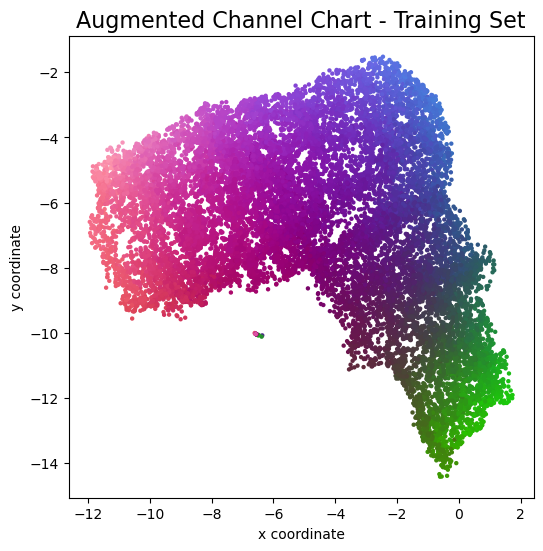

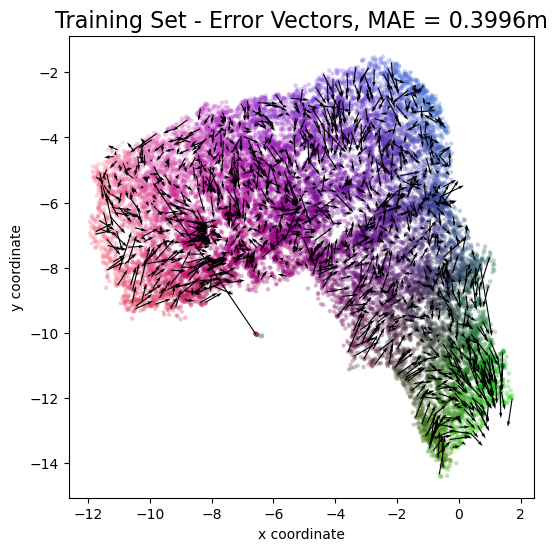

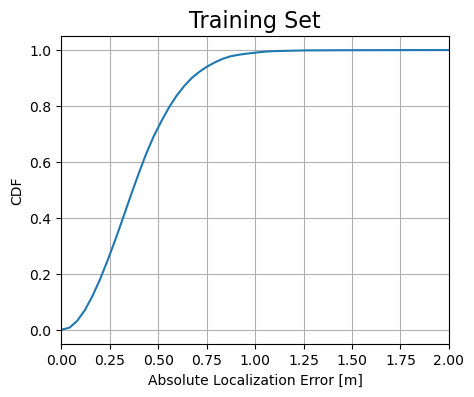

In [24]:
channel_chart_positions = cc_embmodel.predict(csi_time_domain_tensor)
plot_colorized(channel_chart_positions, groundtruth_positions, title = "Augmented Channel Chart - Training Set")
plot_quiver(channel_chart_positions, groundtruth_positions, title = "Training Set")
plot_cdf(channel_chart_positions, groundtruth_positions, title = "Training Set")

### Evaluate on test set

In [25]:
test_set_groundtruth_positions = []

for csi, pos, time in test_set.prefetch(tf.data.AUTOTUNE).batch(1000):
    test_set_groundtruth_positions.append(pos.numpy())

test_set_groundtruth_positions = np.concatenate(test_set_groundtruth_positions)

21/21 [==============================] - 16s 773ms/step


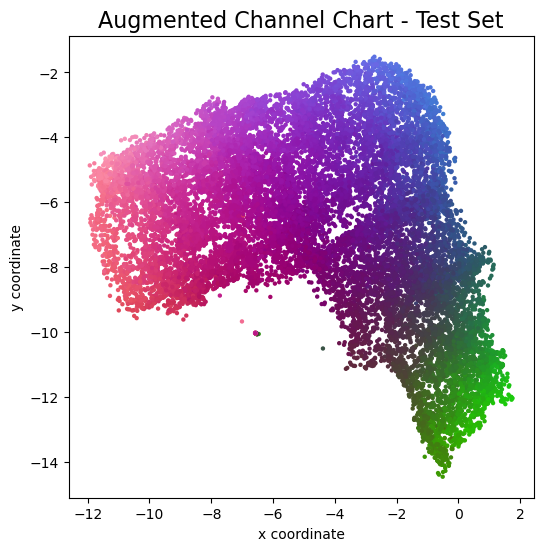

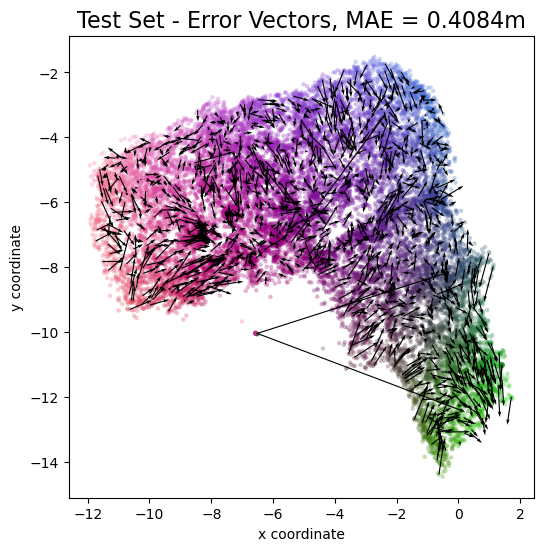

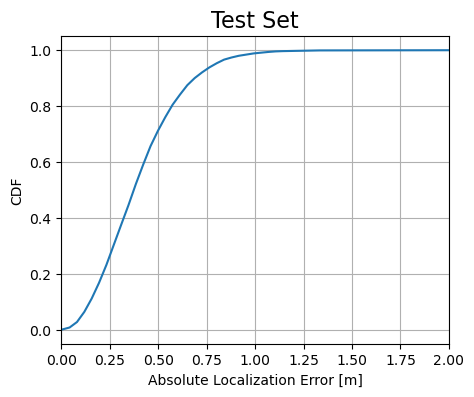

In [26]:
# Plot Channel Chart
channel_chart_positions_testset = cc_embmodel.predict(test_set.prefetch(tf.data.AUTOTUNE).batch(1000))
plot_colorized(channel_chart_positions_testset, test_set_groundtruth_positions, title = "Augmented Channel Chart - Test Set")
plot_quiver(channel_chart_positions_testset, test_set_groundtruth_positions, title = "Test Set")
plot_cdf(channel_chart_positions_testset, test_set_groundtruth_positions, title = "Test Set")